In [1]:
import pandas as pd

In [130]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def cieluv(img, target):
    # Color distance in the CIELUV space
    # RGB space is not good for color detection
    img = img.astype('int')
    aR, aG, aB = img[:,:,0], img[:,:,1], img[:,:,2]
    bR, bG, bB = target
    rmean = ((aR + bR) / 2).astype('int')
    r2 = np.square(aR - bR)
    g2 = np.square(aG - bG)
    b2 = np.square(aB - bB)
    result = (((512+rmean)*r2)>>8) + 4*g2 + (((767-rmean)*b2)>>8)
    result = result.astype('float64')
    result -= result.min()
    result /= result.max()
    result *= 255
    result = result.astype('uint8')

    # skip sqrt for faster computation - just square the threshold instead
    return result

def compute_angle(x1, y1, x2, y2):
    if x2 == x1:
        return 0
    return np.arctan((y2 - y1) / (x2 - x1))


def compute_magnitude(x1, y1, x2, y2):
    return np.sqrt((x2 - x1) ** 2.0 + (y2 - y1) ** 2.0)


def rt_degrees(rt):
    return np.array([[r, np.rad2deg(t)] for r, t in rt])


def find_lines(edges, threshold=65, minLineLength=40, maxLineGap=10):
    # probabilistic hough transform
    lines = cv2.HoughLinesP(
        edges,
        1,
        np.pi / 180,
        threshold,
        minLineLength=minLineLength,
        maxLineGap=maxLineGap,
    )
    if lines is None:
        return []
    lines = [
        line[0]  # (*line[0], compute_magnitude(*line[0]), compute_angle(*line[0]))
        for line in lines
    ]
    return lines


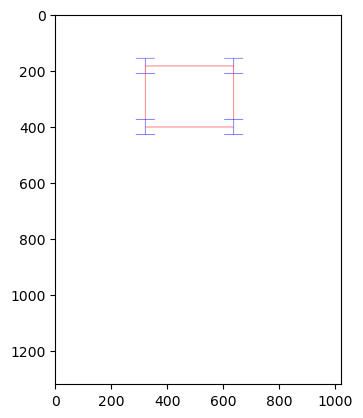

In [70]:
img = cv2.imread("data/plan.png")
plt.imshow(img)

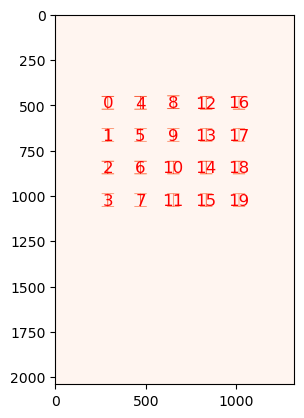

In [282]:
from sklearn.cluster import MeanShift, AffinityPropagation, OPTICS, KMeans

QUANTIZATION_FACTOR = 1

img = plt.imread("data/plan4.png") # bgr??????
# img_r = (255 - img[:, :, 0]).astype(bool).astype(int)
img_r = (cieluv(img, (0, 0, 255)) >= 10).astype(bool)
df = pd.DataFrame(
    find_lines(img_r.astype("uint8") * 255),
    columns=["x1", "y1", "x2", "y2"],
)
df = df[~(df // QUANTIZATION_FACTOR * QUANTIZATION_FACTOR).duplicated()].reset_index(drop=True)
X = (
    df[["x1", "y1", "x2", "y2"]]
    # .floordiv(QUANTIZATION_FACTOR)
    # .mul(QUANTIZATION_FACTOR)
    # .astype(int)
)

ms = KMeans(n_clusters=20) # MeanShift(min_bin_freq=2, cluster_all=False, max_iter=5000)  # KMeans(n_clusters=4)
# ms = MeanShift(min_bin_freq=2, cluster_all=False, max_iter=5000) 
# AffinityPropagation() # MeanShift(min_bin_freq=2, bin_seeding=True) # OPTICS(min_samples=3)
X["cluster"] = ms.fit_predict(X)
X = X[X.cluster != -1].reset_index(drop=True)
columns = pd.concat(
    [
        X.groupby("cluster")[["x1", "y1"]].min(),
        X.groupby("cluster")[["x2", "y2"]].max(),
    ],
    axis=1,
)
ax = plt.imshow(img_r, cmap="Reds")

centroids = (
    pd.DataFrame(
        [((x1 + x2) / 2, (y1 + y2) / 2) for x1, y1, x2, y2 in columns.values],
        columns=["x", "y"],
    )
    .round()
    .astype(int)
    .sort_values(["x", "y"])
    .reset_index(drop=True)
)

for i, (_x, _y) in enumerate(centroids.values):
    plt.text(
        _x,
        _y,
        # f"•",
        f"{i}",
        c="r",
        horizontalalignment="center",
        verticalalignment="center",
        fontdict={"fontsize": 12}
    )

# TODO: Pixel grouper as fallback

# centroids


In [291]:
PAPER_WIDTH, PAPER_HEIGHT = 11, 17
N_STORIES = 5
Z_INTERVAL = 12
ZOOM_FACTOR = 16
FINAL_FACTOR = 12

WIDTH_FACTOR = PAPER_WIDTH / img_r.shape[1]  # inch per pixel
HEIGHT_FACTOR = PAPER_HEIGHT / img_r.shape[0]  # inch per pixel
PIXEL_FACTOR = WIDTH_FACTOR
SCALE_FACTOR = PIXEL_FACTOR * ZOOM_FACTOR

normalized_centroids = (
    pd.DataFrame(
        {
            "x": centroids["x"] - centroids["x"].min(),
            "y": centroids["y"] - centroids["y"].min(),
        }
    )
    * SCALE_FACTOR
)

normalized_centroids_unit = (normalized_centroids).round().astype(int)


# replicate as stories
normalized_centroids_unit_stories = []
Z = 0
for story in range(1, N_STORIES + 1):
    _normalized_centroids_unit = normalized_centroids_unit.copy()
    _normalized_centroids_unit["z"] = Z
    normalized_centroids_unit_stories.append(_normalized_centroids_unit)
    Z += Z_INTERVAL
normalized_centroids_unit_stories = pd.concat(
    normalized_centroids_unit_stories, axis=0, ignore_index=True
)
nodes = normalized_centroids_unit_stories.reset_index().rename(columns={"index": "tag"})
nodes["tag"] += 1
nodes.mul(FINAL_FACTOR).to_excel("nodes.xlsx", index=False)

In [292]:
slab_coordinates = pd.concat(
    [
        pd.concat(
            [nodes.groupby("z")["x"].min(), nodes.groupby("z")["y"].min()], axis=1
        ).reset_index(),
        pd.concat(
            [nodes.groupby("z")["x"].min(), nodes.groupby("z")["y"].max()], axis=1
        ).reset_index(),
        pd.concat(
            [nodes.groupby("z")["x"].max(), nodes.groupby("z")["y"].min()], axis=1
        ).reset_index(),
        pd.concat(
            [nodes.groupby("z")["x"].max(), nodes.groupby("z")["y"].max()], axis=1
        ).reset_index(),
    ],
    axis=0,
    ignore_index=True,
).mul(FINAL_FACTOR)
slab_coordinates.to_excel("slab_coordinates.xlsx", index=False)

In [280]:
nodes.min(), nodes.max()

(tag    1
 x      0
 y      0
 z      0
 dtype: int64,
 tag    100
 x       96
 y       72
 z       48
 dtype: int64)

In [269]:
EPSILON = 2 # 2 feet of allowance
connectivities = []
for _x1, _y1, _z1 in normalized_centroids_unit_stories.values:
    for _x2, _y2, _z2 in normalized_centroids_unit_stories.values:
        if (_x1 == _x2) and (_y1 == _y2) and (_z1 == _z2):
            pass
        if (
            int(abs(_x1 - _x2) < EPSILON)
            + int(abs(_y1 - _y2) < EPSILON)
            + int(abs(_z1 - _z2) < EPSILON)
        ) == 2:
            connectivities.append([_x1, _y1, _z1, _x2, _y2, _z2])
connectivities = pd.DataFrame(
    connectivities, columns=["x1", "y1", "z1", "x2", "y2", "z2"]
)

connectivities["dx"] = (
    (connectivities["x1"] - connectivities["x2"])
    .abs()
    .apply(lambda d: None if d < EPSILON else d)
)
connectivities["dy"] = (
    (connectivities["y1"] - connectivities["y2"])
    .abs()
    .apply(lambda d: None if d < EPSILON else d)
)
connectivities["dz"] = (
    (connectivities["z1"] - connectivities["z2"])
    .abs()
    .apply(lambda d: None if d < EPSILON else d)
)

idx_valid = sorted(
    set(
        connectivities.groupby(["x1", "y1", "z1"]).dx.idxmin().values.tolist()
        + connectivities.groupby(["x1", "y1", "z1"]).dy.idxmin().values.tolist()
        + connectivities.groupby(["x1", "y1", "z1"]).dz.idxmin().values.tolist()
    )
)

connectivities_valid = (
    connectivities.iloc[idx_valid]
    .reset_index(drop=True)
    .drop(["dx", "dy", "dz"], axis=1)
)

connectivities_valid *= FINAL_FACTOR

connectivities_valid.to_excel("connectivities.xlsx", index=False)
connectivities_valid["tag"] = (connectivities_valid.index + 1).tolist()
connectivities_valid

,x1,y1,z1,x2,y2,z2,tag
0,0,0,0,0,288,0,1
1,0,0,0,288,12,0,2
2,0,0,0,0,0,144,3
3,0,288,0,0,0,0,4
4,0,288,0,288,288,0,5
...,...,...,...,...,...,...,...
295,1152,576,576,864,576,576,296
296,1152,576,576,1152,288,576,297
297,1152,864,576,1152,864,432,298
298,1152,864,576,864,864,576,299


In [255]:
connectivities_valid[
    (
        ((connectivities_valid.x2 - connectivities_valid.x1) > EPSILON)
        | ((connectivities_valid.x1 - connectivities_valid.x2).abs() < EPSILON)
    )
    & (
        ((connectivities_valid.y2 - connectivities_valid.y1) > EPSILON)
        | ((connectivities_valid.y1 - connectivities_valid.y2).abs() < EPSILON)
    )
    & (
        ((connectivities_valid.z2 - connectivities_valid.z1) > EPSILON)
        | ((connectivities_valid.z1 - connectivities_valid.z2).abs() < EPSILON)
    )
]


,x1,y1,z1,x2,y2,z2
0,0,0,0,0,24,0
1,0,0,0,24,1,0
2,0,0,0,0,0,12
4,0,24,0,24,24,0
5,0,24,0,0,24,12
...,...,...,...,...,...,...
251,0,72,48,24,72,48
254,24,1,48,24,24,48
266,48,0,48,48,24,48
278,72,0,48,72,24,48


In [246]:
31 * 5 + 20 * 4

235

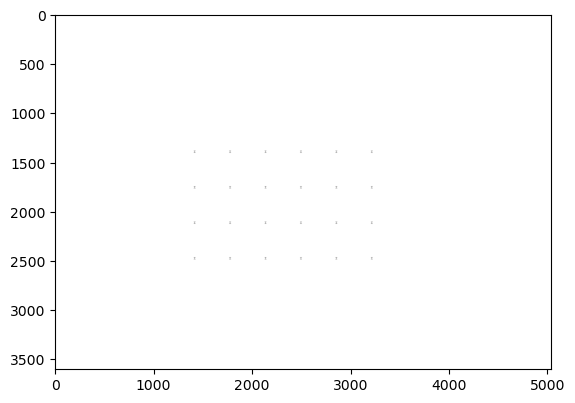

In [73]:
img = cv2.imread("data/plan2-raster.png")
img_r = (cieluv(255 - img, (0, 0, 255)) >= 180).astype(bool).astype(float)
# img_r = cv2.resize(img_r, (1000, 700))
plt.imshow(img_r, cmap="binary")

In [59]:
# plt.imshow(img_r[1200:1200+1500, 1000:3500], cmap="binary")

In [65]:
cv2.imwrite("plan2_red.png", (img_r.astype("uint8") * 255))

True

,x,y
0,1468,2130
1,2520,1800
2,3669,1370


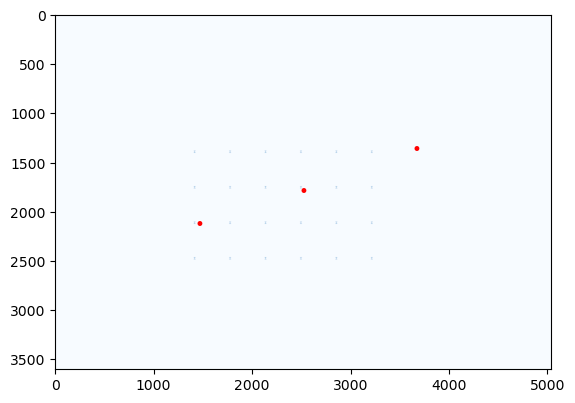

In [74]:
from sklearn.cluster import MeanShift, AffinityPropagation, OPTICS, KMeans

QUANTIZATION_FACTOR = 1

# img = cv2.imread("data/plan2.png")
# img_r = cieluv(255 - img, (255, 0, 0)) # (255 - img[:, :, 0]).astype(bool).astype(int)
# img_g = (255 - img[:, :, 1]).astype(bool).astype(int)
# img_b = (255 - img[:, :, -1]).astype(bool).astype(int)
df = pd.DataFrame(
    find_lines(255 - img_r.astype("uint8") * 255),
    columns=["x1", "y1", "x2", "y2"],
)

X = (
    df[["x1", "y1", "x2", "y2"]]
    .floordiv(QUANTIZATION_FACTOR)
    .mul(QUANTIZATION_FACTOR)
    .astype(int)
)

ms = MeanShift(min_bin_freq=2, bin_seeding=True) #  AffinityPropagation() 
# MeanShift(min_bin_freq=2, bin_seeding=True) 
# AffinityPropagation() # MeanShift(min_bin_freq=2, bin_seeding=True) # OPTICS(min_samples=3)
X["cluster"] = ms.fit_predict(X)
columns = pd.concat(
    [
        X.groupby("cluster")[["x1", "y1"]].min(),
        X.groupby("cluster")[["x2", "y2"]].max(),
    ],
    axis=1,
)
ax = plt.imshow(img_r, cmap="Blues")

centroids = (
    pd.DataFrame(
        [((x1 + x2) / 2, (y1 + y2) / 2) for x1, y1, x2, y2 in columns.values],
        columns=["x", "y"],
    )
    .round()
    .astype(int)
    .sort_values(["x", "y"])
    .reset_index(drop=True)
)

for i, (_x, _y) in enumerate(centroids.values):
    plt.text(
        _x,
        _y,
        f"•",
        c="r",
        horizontalalignment="center",
        verticalalignment="center",
        fontdict={"fontsize": 12}
    )

centroids


In [21]:
X // 32

,x1,y1,x2,y2,cluster
0,0,109,157,109,0
1,0,101,150,0,0
2,26,112,155,0,0
3,0,108,155,0,0
4,32,112,157,18,0
...,...,...,...,...,...
10779,68,112,87,95,0
10780,58,97,77,90,0
10781,145,3,147,2,0
10782,0,52,70,26,0


In [97]:
636 - 322

314

In [95]:
img.shape

(1320, 1020, 3)

In [98]:
8.5 / 1020 * 314 

2.6166666666666667

In [111]:
img.shape

(1320, 1020, 3)

(0.008333333333333333, 0.008333333333333333)

### scale is an input

### bottom left is the origin

### 

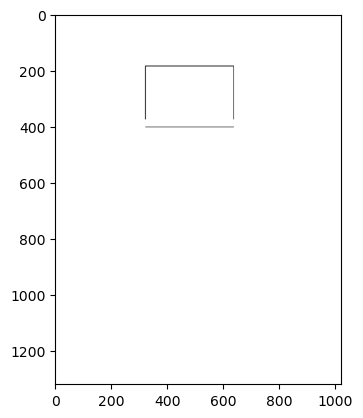

In [91]:
plt.imshow(img_b, cmap="binary")

In [92]:
pd.DataFrame(
    find_lines(img_b.astype("uint8") * 255),
    columns=["x1", "y1", "x2", "y2", "r", "theta"],
)


,x1,y1,x2,y2,r,theta
0,321,186,637,186,316.0,0.0
1,322,403,637,403,315.0,0.0
2,322,402,637,402,315.0,0.0
3,322,184,637,184,315.0,0.0
4,322,185,637,185,315.0,0.0
5,321,375,321,187,188.0,0.0
6,637,375,637,187,188.0,0.0
7,322,375,322,187,188.0,0.0
8,323,375,323,187,188.0,0.0
9,636,375,636,187,188.0,0.0
